In [82]:
import os
from pickle import load
import matplotlib.pyplot as plt
from numpy import array, stack
import torch 
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn 
from torch import optim 
from torchsummary import summary

## Essential System Parameters 

In [83]:
fading = 1
num_ant = 2
max_iter = 100000
SNR_dB = 5
bit_codebook = 2

## Load precoder dataset

In [84]:
dir_name = 'datasets'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
file_name = f'{dir_name}/{fading}_precoder_data_{num_ant}_ant_SNR_{SNR_dB}dB_{bit_codebook}_bit_codebk'
print(file_name)
with open(f'{file_name}.pkl', 'rb') as f:
    precoders, labels = load(f)

datasets/1_precoder_data_2_ant_SNR_5dB_2_bit_codebk


## Visualization of Data

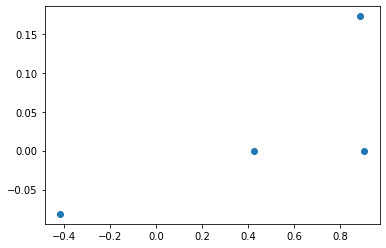

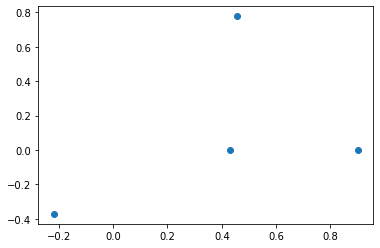

In [85]:
# test plots
for i in range(2):
    plt.scatter(precoders[i][0::2], precoders[i][1::2])
    plt.show()

## Precoder Dataset Class 
1. Package dataset such that it is compatible for PyTorch
2. Split dataset into 80% training and 20% validation
3. Create PyTorch dataloaders for training and validation data

Dataloaders divide the dataset into chincks called batches. We can pass data to the neural network one batch at a time. 

In [86]:
class PrecoderDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.data)

precoder_data = stack(precoders, axis=0)
precoder_labels = array(labels)    

precoder_dataset = PrecoderDataset(precoder_data, precoder_labels)
train, val = random_split(precoder_dataset, [int(0.8*max_iter), int(0.2*max_iter)])
train_loader = DataLoader(train, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size=128, shuffle=True, num_workers=0)

## Neural Network Parameters

In [87]:
learning_rate = 0.001
num_classes = 2**bit_codebook
nn_input_size = 2*num_ant*num_ant
nn_output_size = num_classes

## Neural Network 
1. Define Neural Network Class and create an instance of it
2. Define the loss and optimizer

In [88]:

class Model(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        # define layers and activation function as class parameters
        self.fc1 = nn.Linear(in_features=input_size, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=50)
        self.output = nn.Linear(in_features=50, out_features=output_size)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # define NN connections here, output of last layer is pred
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        pred = self.output(x)
        return pred


model = Model(nn_input_size, nn_output_size)

if torch.cuda.is_available():
    model.cuda()

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

## Training iterations
1. Epoch - one pass of the entire dataset (training + validation). 
2. In each epoch you iterate over several batches.
3. Batch - chunk of data that is fed to the neural network in one go. 

In [89]:
num_epochs = 500 # Number of times you go through the whole dataset
for epoch in range(num_epochs):
    
    # TRAINING
    model.train()
    training_total_correct = 0
    training_losses = list()
    for batch in train_loader:
        
        x, y = batch # extracted from the batch 
        
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        # step 1: forward pass 
        prob = model(x) 
        
        output = prob
        target = y
        
        # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
        obj_func = loss(output, target)
        
        # step 3: clear the gradients 
        model.zero_grad()
        
        # step 4: accumulate partial derivatives of obj_func wrt parameters 
        obj_func.backward()
        
        # step 5: step in the opposite direction of the gradient 
        optimizer.step()

        training_losses.append(obj_func.item())
        
        max_prob, max_ind = torch.max(output, 1)
        for ind in range(len(max_ind)):
            if torch.equal(max_ind[ind], y[ind]):
                training_total_correct += 1    
    
    # VALIDATION
    model.eval()

    validation_total_correct = 0
    validation_losses = list()
    for batch in val_loader:
        
        x, y = batch # extracted from the batch 
        
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        # step 1: forward pass 
        with torch.no_grad():
            prob = model(x) 
        
        output = prob
        target = y
        
        # step 2: compute objective function - measuring distance between the output of the network vs actual answer 
        obj_func = loss(output, target)
        validation_losses.append(obj_func.item())
        
        max_prob, max_ind = torch.max(output, 1)
        
        for ind in range(len(max_ind)):
            if torch.equal(max_ind[ind], y[ind]):
                validation_total_correct += 1
    training_accuracy = (training_total_correct/len(train))*100  
    validation_accuracy = (validation_total_correct/len(val))*100   
    
    print(f'Epoch {epoch + 1}, training loss: {torch.tensor(training_losses).mean():.8f}, training accuracy: {training_accuracy}%, validation loss: {torch.tensor(validation_losses).mean():.8f}, validation accuracy: {validation_accuracy}%')

Epoch 1, training loss: 1.15499008, training accuracy: 48.45375%, validation loss: 1.14761531, validation accuracy: 48.655%
Epoch 2, training loss: 1.13577557, training accuracy: 48.97375%, validation loss: 1.14482725, validation accuracy: 48.69%
Epoch 3, training loss: 1.13416409, training accuracy: 49.0525%, validation loss: 1.14344299, validation accuracy: 48.725%
Epoch 4, training loss: 1.13360941, training accuracy: 49.0625%, validation loss: 1.14199519, validation accuracy: 48.64%
Epoch 5, training loss: 1.13338065, training accuracy: 49.13625%, validation loss: 1.14262819, validation accuracy: 48.745%
Epoch 6, training loss: 1.13254154, training accuracy: 49.11125%, validation loss: 1.14226735, validation accuracy: 48.71%
Epoch 7, training loss: 1.13243365, training accuracy: 49.03125%, validation loss: 1.14384866, validation accuracy: 48.665000000000006%
Epoch 8, training loss: 1.13231862, training accuracy: 49.02125%, validation loss: 1.14357996, validation accuracy: 48.745%
E